## 다람쥐, 쥐, 토끼의 COI 염기서열 140개 무작위 추출 후 aln으로 저장

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   

## 원본과 예측값 비교를 위한 시각화 

In [4]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
species = ['Rattus rattus', 'Mus musculus', 'Microtus fortis', 'Tamias sibiricus', 'Pteromys volans',
            'Sciurus vulgaris', 'Cricetulus barabensis', 'Myodes rutilus', 'Apodemus agrarius']

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    for id in Idlist:
        getFasta(id)

## creating MT932266.1.fasta...
## creating NC_012374.1.fasta...
## creating MN536017.1.fasta...


KeyboardInterrupt: 

In [2]:
getAln('all_coi.fasta')

/Users/kimjoonsu/muscle3.8.31_i86darwin64 -in all_coi.fasta -out all_coi.aln -clw


## 데이터 전처리 및 DataFrame 구성

* DataFrame의 Target 구성을 위해 종(species) 크롤링 

In [2]:
from Bio import SeqIO
from Bio import Entrez
from Bio import GenBank

Entrez.email = "nagabuti13@naver.com"

#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    return r

In [3]:
from Bio import AlignIO
import pandas as pd
alignment = AlignIO.read('all_coi.aln', 'clustal')
length = []
count = 0
start, end = 0, 0
k = 3
mer = ''
for record in alignment:
    count = 0
    for i in range(len(record.seq)):
        mer = record.seq[i:i + k]
        if(count == 1 and mer.count('-') == 2):
            end = i
            break
        elif(mer.count('-') == 3):
            continue
        elif(count != 1):
            start = i + k - 1
            count = 1
        #print(start, end)
    length.append(end - start + 1)
length.sort()
pd.DataFrame(length).value_counts()

658     31
677     21
517     20
669     16
5        7
656      6
651      5
704      4
654      3
650      3
1541     3
599      2
1540     2
1525     2
597      2
580      2
600      1
653      1
601      1
644      1
606      1
576      1
546      1
678      1
530      1
713      1
1377     1
1378     1
639      1
614      1
604      1
dtype: int64

* DataFrame의 열(feature) 구성을 위해 k-mer(k = 3)을 활용

In [4]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('all_coi.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getGenbank(record.id).organism
    index = 0
    if(len(record.seq[61:578]) >= k):
        while(index + k <= 517):
            mer = record.seq[61:578][index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [5]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,6,2,10,18,4,6,14,6,9,2,...,4,9,3,6,10,17,9,10,15,Cricetulus barabensis
1,7,0,11,18,4,7,13,5,8,4,...,3,8,5,9,13,16,7,14,12,Cricetulus barabensis
2,7,0,11,17,4,8,13,5,8,4,...,3,9,5,9,12,16,7,13,12,Cricetulus barabensis
3,4,2,15,15,2,9,13,5,12,4,...,4,13,3,11,10,11,7,12,7,Myodes rutilus
4,5,2,13,17,2,6,13,8,9,4,...,3,12,9,10,7,10,5,12,9,Microtus fortis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,Pteromys volans
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,Pteromys volans
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,Pteromys volans
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,Pteromys volans


## 1. 점수 매기기

In [14]:
arr = np.zeros((144, 144), dtype = 'int32')
scores = pd.DataFrame(arr)
scores

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
for i in df.index:
    for j in df.index:
        for k in df.columns[:-1]:
            scores.loc[i, j] += abs(df.loc[i, k] - df.loc[j, k])
            #[220719_1233]NOTED 데이터프레임의 원소를 수정할 때는 df.loc[j, 'score']을 사용해야 한다.    

In [52]:
for i in df.index:
    for j in df.index:
        for k in df.columns[:-1]:
            if(df.loc[i, k] == df.loc[j, k]):
                scores.loc[i, j] += 1

In [68]:
scores #[220719_1334]NOTED 대칭행렬

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0,49,39,105,103,97,97,93,97,97,...,73,49,49,49,59,59,59,59,61,61
1,49,0,14,82,80,74,74,70,74,74,...,52,62,62,62,60,50,52,64,56,62
2,39,14,0,84,82,76,76,72,76,76,...,54,62,62,62,62,50,52,64,60,64
3,105,82,84,0,52,50,50,48,50,50,...,114,126,126,126,128,118,122,134,132,132
4,103,80,82,52,0,6,6,10,6,6,...,118,128,128,128,124,112,116,128,124,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,59,50,50,118,112,110,110,106,110,110,...,46,36,36,36,16,0,4,18,14,16
140,59,52,52,122,116,114,114,110,114,114,...,42,36,36,36,12,4,0,16,14,12
141,59,64,64,134,128,126,126,122,126,126,...,56,30,30,30,12,18,16,0,14,4
142,61,56,60,132,124,122,122,118,122,122,...,48,36,36,36,14,14,14,14,0,12


## 2. Top 5 추출

In [69]:
scores.iloc[21].nsmallest(10, keep = 'all') 

20    0
21    0
18    4
30    4
31    4
32    4
35    4
36    4
37    4
38    4
Name: 21, dtype: int64

In [24]:
df[df['target'] == 'Myodes rutilu'].index
#[220719_1358]NOTED 상위 5개로 설정할 시 Cricetulus barabensi의 경우 개체가 3개이기 때문에 다른 종 두 개체가 변이를 제거하는데 쓰일 가능성이 있음 => 상위 5 -> 3개로 수정하는 것이 좋을 수도 있음

Int64Index([ 3, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
            30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
           dtype='int64')

## 개체 가공

1. 가공해야 할 개체를 제외한 다른 임이의 5개 개체의 유전자 분포 조사


In [15]:
myru_indexs = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
            30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
list1 = []
list2 = []
list3 = []
for index in myru_indexs:
    list1.append(list(alignment[index].seq[61:578]))
for i in range(len(list1[0])):
    for sequence in list1:
        list2.append(sequence[i])
    list3.append(min(list2, key = list2.count))
    list2 = []
#[220724_1311]CREATED 동일 종 5개 개체 간의 염기를 비교하여 확률적으로 가장 이상적인(target에 가까운) 염기 계산

2. 가공해야 할 개체에 근접하는 새로운 염기서열 개체를 구성

In [16]:
sequecne = ''.join(list3)

k = 2
dict = {}
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장

init(dict)
#[220509_1517]NOTED getOrganism() 호출
dict['target'] = ''
index = 0
if(len(sequecne) >= k):
    while(index + k <= 517):
        mer = sequecne[index:index + k]
        if(mer.find('-') != -1):
            #dict['---'] += 1
            index += 1
            continue
        #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
        for p in range(k):
            mer = mer.replace(mer[p], base_dict.get(mer[p]))
            
        dict[mer] += 1
        index += 1
df = df.append(dict, ignore_index = True)
df

,AA,AG,AC,AT,GA,GG,GC,GT,CA,CG,CC,CT,TA,TG,TC,TT,target
0,36,30,31,52,20,20,24,15,37,7,27,39,55,23,28,51,Cricetulus barabensi
1,36,29,31,48,24,25,24,18,34,13,30,43,50,25,35,49,Cricetulus barabensi
2,35,30,31,50,23,25,24,18,36,12,29,42,52,24,35,48,Cricetulus barabensi
3,36,29,33,45,21,30,26,17,48,13,46,35,38,23,37,37,Myodes rutilu
4,37,29,34,43,18,28,31,21,45,20,32,37,43,22,38,36,Microtus forti
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,32,32,27,48,23,23,24,22,29,10,33,41,55,28,30,57,Pteromys volan
141,32,33,27,49,25,20,24,21,28,10,33,40,56,28,28,60,Pteromys volan
142,32,33,27,48,24,21,25,21,28,9,32,43,56,29,29,57,Pteromys volan
143,32,33,27,48,24,21,24,22,28,10,33,40,56,28,28,60,Pteromys volan


In [17]:
arr = np.zeros((145, 145), dtype = 'int32')
scores = pd.DataFrame(arr)
scores

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


3. 가공해야 할 개체와의 유사도 비교

In [18]:
for i in df.index:
    for j in df.index:
        for k in df.columns[:-1]:
            scores.loc[i, j] += abs(df.loc[i, k] - df.loc[j, k])
            #[220719_1233]NOTED 데이터프레임의 원소를 수정할 때는 df.loc[j, 'score']을 사용해야 한다.  
scores  

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0,49,39,105,103,97,97,93,97,97,...,49,49,49,59,59,59,59,61,61,117
1,49,0,14,82,80,74,74,70,74,74,...,62,62,62,60,50,52,64,56,62,98
2,39,14,0,84,82,76,76,72,76,76,...,62,62,62,62,50,52,64,60,64,96
3,105,82,84,0,52,50,50,48,50,50,...,126,126,126,128,118,122,134,132,132,64
4,103,80,82,52,0,6,6,10,6,6,...,128,128,128,124,112,116,128,124,126,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,59,52,52,122,116,114,114,110,114,114,...,36,36,36,12,4,0,16,14,12,118
141,59,64,64,134,128,126,126,122,126,126,...,30,30,30,12,18,16,0,14,4,126
142,61,56,60,132,124,122,122,118,122,122,...,36,36,36,14,14,14,14,0,12,124
143,61,62,64,132,126,124,124,120,124,124,...,34,34,34,10,16,12,4,12,0,124


In [19]:
scores.iloc[3].nsmallest(30, keep = 'all') 

3       0
10     46
11     46
12     46
13     46
7      48
5      50
6      50
8      50
9      50
4      52
14     60
20     60
21     60
39     60
18     62
37     62
38     62
40     62
41     62
15     64
16     64
17     64
30     64
31     64
32     64
34     64
35     64
36     64
144    64
Name: 3, dtype: int64

## K-means로 9개 종 군집화

### K값 선택

In [6]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[1 1 1 4 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5 5 5 5 5]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,6,2,10,18,4,6,14,6,9,2,...,4,9,3,6,10,17,9,10,15,1
1,7,0,11,18,4,7,13,5,8,4,...,3,8,5,9,13,16,7,14,12,1
2,7,0,11,17,4,8,13,5,8,4,...,3,9,5,9,12,16,7,13,12,1
3,4,2,15,15,2,9,13,5,12,4,...,4,13,3,11,10,11,7,12,7,4
4,5,2,13,17,2,6,13,8,9,4,...,3,12,9,10,7,10,5,12,9,2


In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam_target'] = silhouette_samples(df.loc[:, :'TTT'], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df.loc[:, :'TTT'], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam_target'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용

전체 실루엣 계수 평균: 0.748
군집 별 실루엣 계수 평균: 
target
0    0.805125
1    0.507269
2    0.888037
3    0.844756
4    0.746277
5    0.560666
6    0.754436
7    0.936542
8    0.632106
Name: sil_sam_target, dtype: float64
score: 0.115


* elbow method

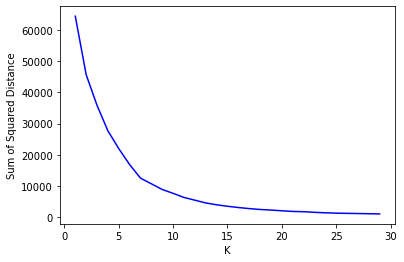

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 500)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220801_1625]CREATED elbow가 존재하지 않음 -> 활용 불가

* silhouette

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    sil_tot = silhouette_score(df.iloc[:, :-3], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.328
군집 별 실루엣 계수 평균: 
cluster
0    0.542063
1    0.248239
Name: sil_sam, dtype: float64
score: 0.147
---------------
전체 실루엣 계수 평균: 0.406
군집 별 실루엣 계수 평균: 
cluster
0    0.326326
1    0.416426
2    0.519194
Name: sil_sam, dtype: float64
score: 0.068
---------------
전체 실루엣 계수 평균: 0.495
군집 별 실루엣 계수 평균: 
cluster
0    0.468392
1    0.776096
2    0.381918
3    0.410160
Name: sil_sam, dtype: float64
score: 0.126
---------------
전체 실루엣 계수 평균: 0.578
군집 별 실루엣 계수 평균: 
cluster
0    0.314704
1    0.772042
2    0.665903
3    0.420760
4    0.775858
Name: sil_sam, dtype: float64
score: 0.180
---------------
전체 실루엣 계수 평균: 0.656
군집 별 실루엣 계수 평균: 
cluster
0    0.313704
1    0.825629
2    0.665903
3    0.819897
4    0.774815
5    0.555544
Name: sil_sam, dtype: float64
score: 0.151
---------------
전체 실루엣 계수 평균: 0.708
군집 별 실루엣 계수 평균: 
cluster
0    0.819897
1    0.825629
2    0.939952
3    0.762114
4    0.647600
5    0.554577
6    0.246485
Name: sil_sam, dtype: float64
score: 0.170
--------------

### 테스트 데이터에서의 정확도 

In [40]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

In [42]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

kmeans = KMeans(n_clusters = 9, init='k-means++', max_iter=500)
kmeans.fit(df.loc[:,:'TTT'])
print(cal_accuracy(df['target'], kmeans.labels_))

0.8690080885483185


In [43]:
df['cluster'] = kmeans.labels_

* PCA(차원 축소)

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.loc[:, :'TTT'])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,ACC,ACT,ATA,ATG,ATC,ATT,GAA,GAG,GAC,GAT,GGA,GGG,GGC,GGT,GCA,GCG,GCC,GCT,GTA,GTG,GTC,GTT,CAA,CAG,CAC,CAT,CGA,CGG,CGC,CGT,CCA,CCG,CCC,CCT,CTA,CTG,CTC,CTT,TAA,TAG,TAC,TAT,TGA,TGG,TGC,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target,cluster,pca_x,pca_y
0,7,2,12,21,6,8,15,7,13,2,13,15,20,4,18,23,8,5,2,11,12,4,5,4,10,2,5,10,9,4,2,7,10,15,8,13,0,2,2,5,12,1,9,13,21,11,6,16,17,14,22,19,8,11,5,6,11,4,8,16,22,11,13,20,1,4,-5.955770,-2.846912
1,7,0,13,21,6,9,14,6,12,4,11,14,19,4,19,23,8,8,2,10,10,5,6,8,10,1,7,9,9,5,3,7,8,14,7,13,4,4,2,6,11,5,9,15,19,10,6,20,18,13,18,21,8,11,5,4,9,6,13,18,23,8,19,16,1,4,-4.534525,-6.522156
2,7,0,13,20,6,10,14,6,12,4,11,14,20,4,20,23,7,8,2,10,10,5,6,8,11,1,6,9,9,5,3,7,8,15,7,14,3,4,2,6,11,4,9,15,20,9,6,19,18,13,18,23,8,10,5,4,10,6,13,17,23,8,18,16,1,4,-4.452925,-6.769762
3,6,2,18,16,4,11,15,6,15,5,12,14,14,4,18,16,9,6,6,7,11,8,6,9,13,0,11,6,6,6,5,5,15,16,12,16,7,6,3,1,16,8,22,16,11,9,12,19,12,12,9,13,6,9,6,6,15,4,17,16,15,7,18,9,4,6,7.466733,-2.978317
4,5,2,17,18,4,9,14,8,13,4,20,14,16,4,13,16,8,8,9,2,10,7,10,5,13,3,8,10,11,2,8,4,12,13,13,15,5,7,5,7,14,7,10,21,16,14,13,17,17,12,12,14,7,9,5,5,13,10,15,15,12,5,19,10,2,6,12.997985,-6.175282


* <원본>

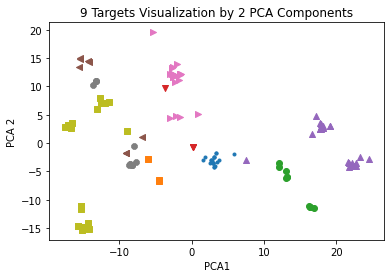

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

* <예측값>

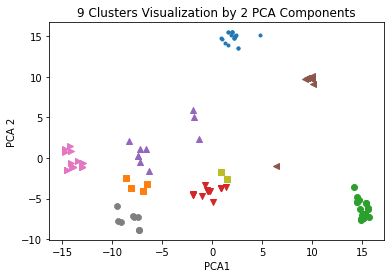

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

In [32]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8
target,,,,,,,,,
0,21,0,0,0,0,0,0,0,0
1,0,0,0,0,3,0,0,0,0
2,0,0,0,0,0,10,0,0,0
3,0,0,0,0,0,0,0,0,4
4,0,0,28,0,0,1,0,0,0
5,0,0,0,0,0,0,0,9,0
6,0,0,0,23,0,0,0,0,0
7,0,15,0,0,0,0,0,0,0
8,0,0,0,0,7,0,23,0,0
